# **1. Inference**

Deploy the trained tomato leaf disease classification model using TensorFlow Serving within a Docker container. This approach provides a robust and scalable solution for serving the model in a production environment.

**Benefits of using TensorFlow Serving and Docker:**

* **Robust and Scalable Deployment:** TensorFlow Serving enables efficient model management, versioning, and handling of incoming inference requests, ensuring a reliable and scalable solution for serving the model.
* **Consistent Deployment Across Environments:** Docker allows the model to be packaged and deployed consistently across various environments, ensuring portability and reproducibility.
* **Real-Time Prediction Capabilities:** This setup enables real-time prediction capabilities for tomato leaf disease classification, allowing for quick and accurate diagnosis based on uploaded images.

**The following steps demonstrate the process of deploying the model:**

1. [**Export the trained model:**](https://github.com/kevinadityaikhsan/tomato_leaf_disease_classification) The trained Keras model is exported in a format suitable for TensorFlow Serving.
2. **Create a Docker image:** A Docker image is built containing TensorFlow Serving and the exported model.
    ```
    docker run -it -v tomato-leaf-disease-classification\models:/models -p 8501:8501 --entrypoint /bin/bash tensorflow/serving
    ```
3. **Run the Docker container:** The Docker container is launched, exposing a REST API for receiving inference requests.
    ```
    tensorflow_model_server --rest_api_port=8501 --model_name=saved_model --model_base_path=/models/saved_model/
    ```
4. **Send inference requests:** Client applications can send image data to the REST API, and the model will return predictions regarding the type of tomato leaf disease, which the step is as follows.

## **1.1. Image Preprocessing**

The `images_preprocessing` function prepares an image for input into the trained model.
It takes the filename of an image as input and performs the following steps:
1. Decodes the image from its file format into a tensor with 3 color channels (RGB).
2. Resizes the image to 224x224 pixels, which is the input size expected by the model.
3. Normalizes the pixel values by dividing them by 255, bringing them to a range of 0 to 1.
4. Expands the dimensions of the image tensor to match the model's input format (adding a batch dimension).
5. Converts the tensor to a Python list, suitable for sending to the model for inference.
This function ensures that images are consistently formatted before being fed into the model, promoting accurate and efficient prediction.


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

# Function to preprocess images for the model.
def images_preprocessing(filename):
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255

    image_tensor = tf.expand_dims(image, 0)
    image_tensor = image_tensor.numpy().tolist()

    return image_tensor

# Dictionary mapping numerical labels to disease names.
map_labels = {
    0: "Bacterial_spot",
    1: "Early_blight",
    2: "Late_blight",
    3: "Leaf_Mold",
    4: "Septoria_leaf_spot",
    5: "Spider_mites Two-spotted_spider_mite",
    6: "Target_Spot",
    7: "Tomato_Yellow_Leaf_Curl_Virus",
    8: "Tomato_mosaic_virus",
    9: "healthy",
    10: "powdery_mildew"
}

# Endpoint for the TensorFlow Serving model.
endpoint = "http://localhost:8501/v1/models/saved_model:predict"


## **1.2. Single Prediction**

Demonstrates how to use the deployed model to classify a single tomato leaf image.
It takes the filename of an image as input and performs the following steps:
1. `images_preprocessing`: Preprocesses the image using the function defined earlier to prepare it for input into the model.
2. `json_data`: Creates a JSON payload containing the preprocessed image tensor, ready to be sent to the model.
3. `response`: Sends a POST request to the TensorFlow Serving endpoint with the JSON payload.
4. `prediction`: Extracts the predicted label from the model's response. The model outputs a probability distribution over all possible classes, and the `tf.argmax` function finds the class with the highest probability.
5. `actual_label`: Extracts the actual label of the image from its filename (assuming the filename follows a specific structure).
6. `Display the image`: Displays the image with the predicted and actual labels, allowing for visual verification of the model's performance.

The deployed model can be used to make predictions on new images, highlighting the workflow for real-time inference.


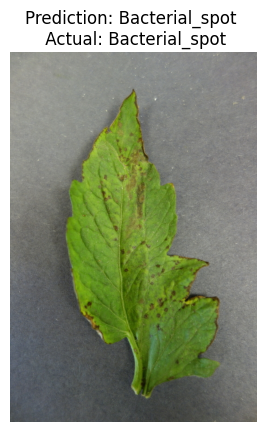

In [3]:
# Input image.
filename = r"tomato-leaf-disease-classification\images\Bacterial_spot\BS_(73).jpg" 
image_tensor = images_preprocessing(filename=filename)

json_data = {
    "instances": image_tensor
}

response = requests.post(endpoint, json=json_data)
prediction = tf.argmax(response.json()['predictions'][0]).numpy()

# Extract actual label from filename.
actual_label = filename.split(os.path.sep)[-2] 

# Display the image.
img = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
plt.imshow(img)
plt.title(f"Prediction: {map_labels[prediction]} \n Actual: {actual_label}")
plt.axis('off')
plt.show()


## **1.3. Batch Prediction**
Demonstrates how to use the deployed model to classify multiple tomato leaf images in a batch. It takes a directory containing subfolders of images as input and performs the following steps for each image:
1. `images_preprocessing`: Preprocesses the image using the function defined earlier to prepare it for input into the model.
2. `json_data`: Creates a JSON payload containing the preprocessed image tensor, ready to be sent to the model.
3. `response`: Sends a POST request to the TensorFlow Serving endpoint with the JSON payload.
4. `prediction`: Extracts the predicted label from the model's response. The model outputs a probability distribution over all possible classes, and the `tf.argmax` function finds the class with the highest probability.
5. `Store the image, prediction, and actual label`: Stores the image, its corresponding prediction, and its actual label in lists for later display and evaluation.
6. `Display the images`: Creates a single figure with multiple subplots, each displaying an image along with its predicted and actual labels, allowing for visual verification of the model's performance on a batch of images.

The deployed model can be used to make predictions on a set of images, highlighting the workflow for batch inference and evaluation.


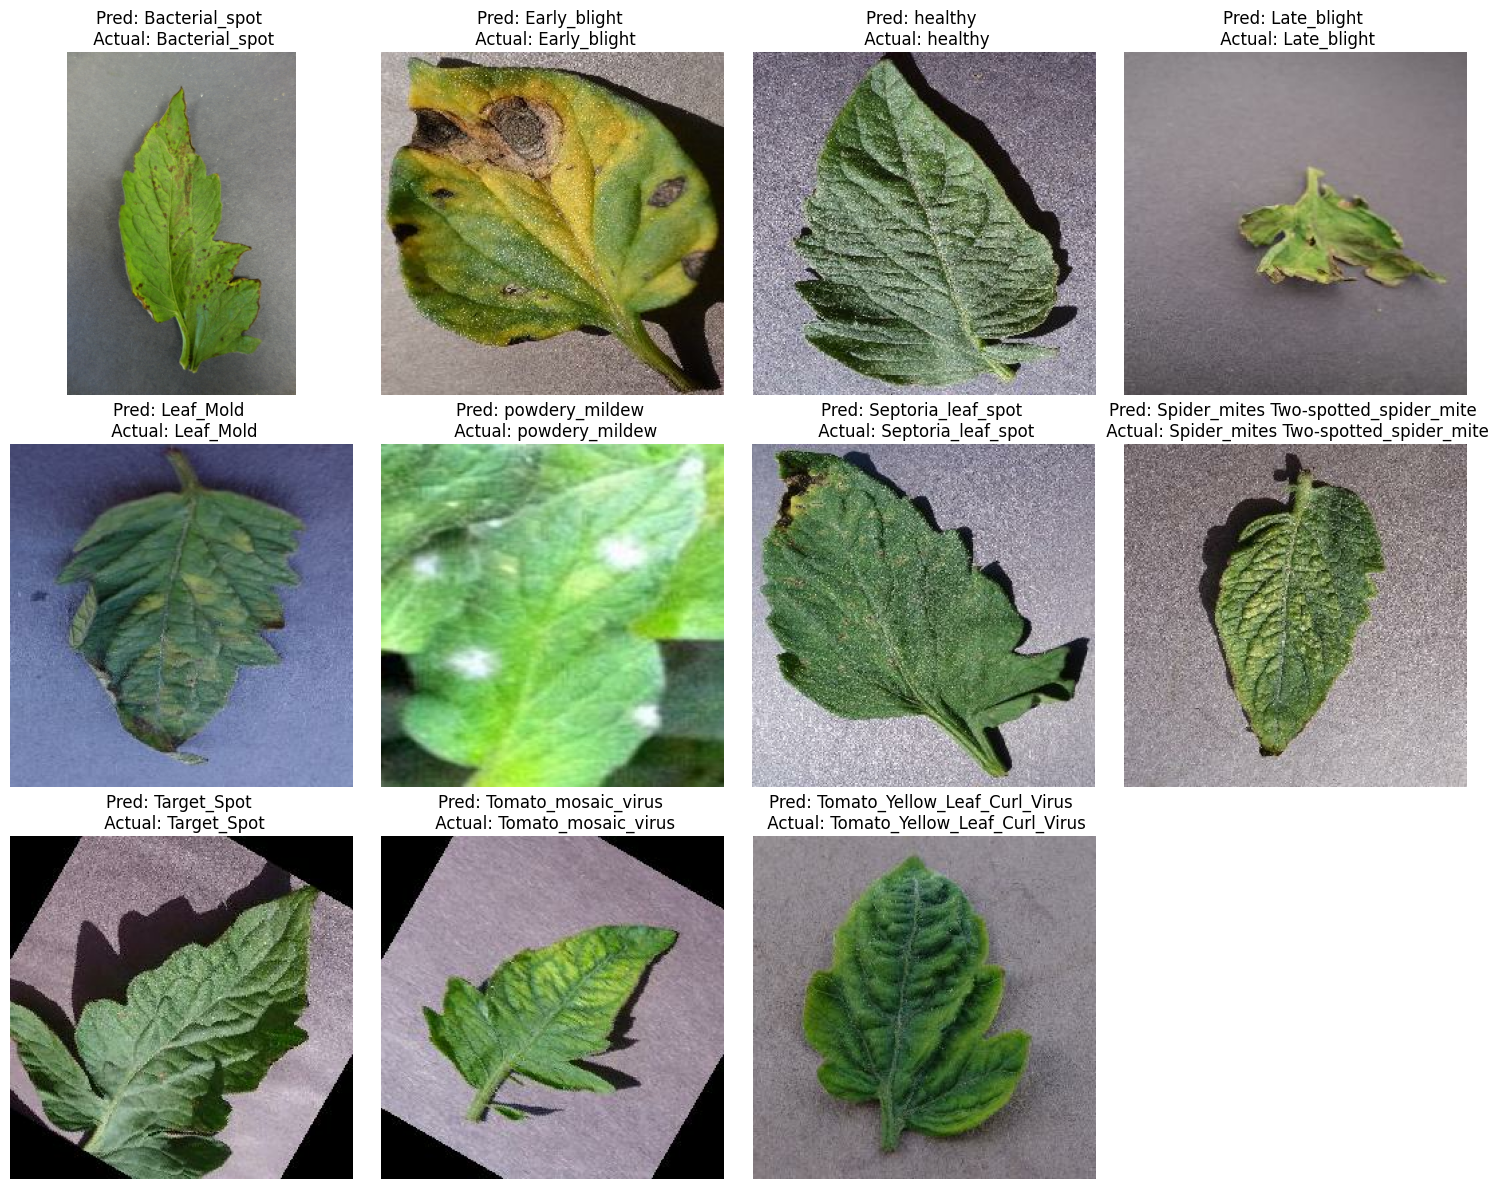

In [4]:
# Input folder.
image_dir = r"tomato-leaf-disease-classification\images"
subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

all_images = []
all_predictions = []
all_actual_labels = []

for subfolder in subfolders:
    subfolder_path = os.path.join(image_dir, subfolder)
    image_files = os.listdir(subfolder_path)

    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        image_tensor = images_preprocessing(image_path)

        json_data = {
            "instances": image_tensor
        }

        response = requests.post(endpoint, json=json_data)
        prediction = tf.argmax(response.json()['predictions'][0]).numpy()

        # Store the image, prediction, and actual label
        all_images.append(tf.io.decode_image(open(image_path, 'rb').read(), channels=3))
        all_predictions.append(prediction)
        all_actual_labels.append(subfolder)

# Determine the number of rows and columns for the single figure
total_images = len(all_images)
num_cols = 4
num_rows = (total_images + num_cols - 1) // num_cols

# Create the single figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Display all images in the single figure
for i in range(total_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(all_images[i])
    ax.set_title(f"Pred: {map_labels[all_predictions[i]]} \n Actual: {all_actual_labels[i]}")
    ax.axis('off')

# Hide any empty subplots
for i in range(total_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## **1.4. Conclusion**

1. **Model Deployment:** The model is deployed using TensorFlow Serving within a Docker container, enabling real-time inference and batch prediction capabilities.
2. **Inference:** The deployed model is used to classify single and batch images, demonstrating the workflow for real-time and batch inference.

The demonstrates a powerful tool for early tomato leaf disease detection. The model's accuracy holds great promise for helping farmers and agricultural experts take timely action, safeguarding crops and minimizing losses.